# Inspecting Data 

In [2]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform

## First let's inspect our labeled landcover dataset

In [5]:
# Open our raster dataset
label_dataset = rasterio.open('/deep_data/NLCD/NLCD_2001_Land_Cover_L48_20190424.img')
label_image = label_dataset.read()

# How many bands does this image have?
num_bands = label_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = label_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = label_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
label_proj = label_dataset.crs
print('Image projection:')
print(label_proj)

Number of bands in image: 1

Image size is: 17107 rows x 21332 columns

Raster driver: GTiff

Image projection:
EPSG:32618


### What is the pixel size?

In [6]:
gt = label_dataset.transform
print(gt)

| 30.00, 0.00,-130215.00|
| 0.00,-30.00, 4187595.00|
| 0.00, 0.00, 1.00|


In [7]:
pixelSizeX = gt[0]
pixelSizeY =-gt[4]

print(pixelSizeX)
print(pixelSizeY)

30.0
30.0


#### What is the image shape?

#### Image is too big to open as a single file so we need to open with a window

In [119]:
from shapely.geometry import Polygon

raster_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)

l8_proj = Proj(image_dataset.crs)
label_proj = Proj(label_dataset.crs)
new_raster_points = []
# convert the raster bounds from landsat into label crs
for x,y in raster_points:
    x, y = transform(l8_proj,label_proj,x,y)
    # convert from crs into row, col in label image coords
    row, col = label_dataset.index(x, y)
    new_raster_points.append((col, row))

# turn this into a polygon
raster_poly = Polygon(new_raster_points)

with rasterio.open('/deep_data/NLCD/NLCD_2016_Land_Cover_L48_20190424.img') as src:
    # Window.from_slices((row_start, row_stop), (col_start, col_stop))
    label_image = src.read(window=Window.from_slices((int(raster_poly.bounds[1]), int(raster_poly.bounds[3])), (int(raster_poly.bounds[0]), int(raster_poly.bounds[2]))))
    
label_image.shape

(1, 5000, 5000)

In [8]:
label_image = label_dataset.read()

#### how many classes are there?

In [138]:
label_dataset.count

1

In [120]:
np.unique(label_image)

array([11, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95],
      dtype=uint8)

#### For now I'm just combining all pixels currently classified as 255 into class 1

But it might be worth combining other classes here too and saving out the raster as something new


In [7]:
label_image[label_image == 255] = 1

Let's take a look at it

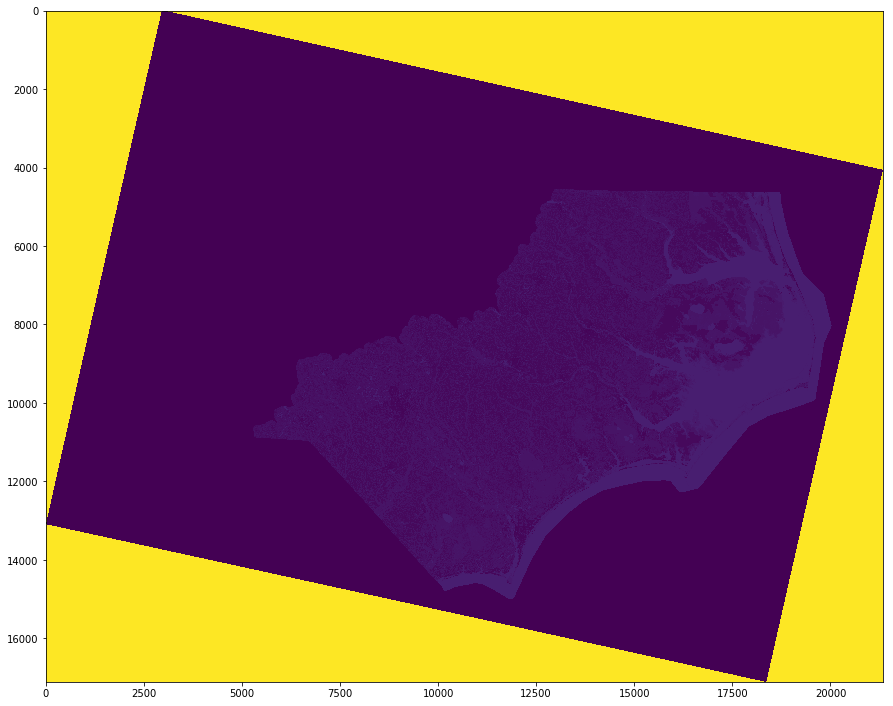

In [9]:
fig, ax = plt.subplots(figsize=[15,15])
ax.imshow(label_image[0])

In [ ]:
Class \ Value	Classification Description
Water	 
11	Open Water- areas of open water, generally with less than 25% cover of vegetation or soil.
12	Perennial Ice/Snow- areas characterized by a perennial cover of ice and/or snow, generally greater than 25% of total cover.
Developed	 
21	Developed, Open Space- areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20% of total cover. These areas most commonly include large-lot single-family housing units, parks, golf courses, and vegetation planted in developed settings for recreation, erosion control, or aesthetic purposes.
22	Developed, Low Intensity- areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20% to 49% percent of total cover. These areas most commonly include single-family housing units.
23	Developed, Medium Intensity -areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50% to 79% of the total cover. These areas most commonly include single-family housing units.
24	Developed High Intensity-highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses and commercial/industrial. Impervious surfaces account for 80% to 100% of the total cover.
Barren	 
31	Barren Land (Rock/Sand/Clay) - areas of bedrock, desert pavement, scarps, talus, slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits and other accumulations of earthen material. Generally, vegetation accounts for less than 15% of total cover.
Forest	 
41	Deciduous Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species shed foliage simultaneously in response to seasonal change.
42	Evergreen Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species maintain their leaves all year. Canopy is never without green foliage.
43	Mixed Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. Neither deciduous nor evergreen species are greater than 75% of total tree cover.
Shrubland	 
51	Dwarf Scrub- Alaska only areas dominated by shrubs less than 20 centimeters tall with shrub canopy typically greater than 20% of total vegetation. This type is often co-associated with grasses, sedges, herbs, and non-vascular vegetation.
52	Shrub/Scrub- areas dominated by shrubs; less than 5 meters tall with shrub canopy typically greater than 20% of total vegetation. This class includes true shrubs, young trees in an early successional stage or trees stunted from environmental conditions.
Herbaceous	 
71	Grassland/Herbaceous- areas dominated by gramanoid or herbaceous vegetation, generally greater than 80% of total vegetation. These areas are not subject to intensive management such as tilling, but can be utilized for grazing.
72	Sedge/Herbaceous- Alaska only areas dominated by sedges and forbs, generally greater than 80% of total vegetation. This type can occur with significant other grasses or other grass like plants, and includes sedge tundra, and sedge tussock tundra.
73	Lichens- Alaska only areas dominated by fruticose or foliose lichens generally greater than 80% of total vegetation.
74	Moss- Alaska only areas dominated by mosses, generally greater than 80% of total vegetation.
Planted/Cultivated	 
81	Pasture/Hay-areas of grasses, legumes, or grass-legume mixtures planted for livestock grazing or the production of seed or hay crops, typically on a perennial cycle. Pasture/hay vegetation accounts for greater than 20% of total vegetation.
82	Cultivated Crops -areas used for the production of annual crops, such as corn, soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as orchards and vineyards. Crop vegetation accounts for greater than 20% of total vegetation. This class also includes all land being actively tilled.
Wetlands	 
90	Woody Wetlands- areas where forest or shrubland vegetation accounts for greater than 20% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.
95	Emergent Herbaceous Wetlands- Areas where perennial herbaceous vegetation accounts for greater than 80% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.

In [79]:
unique, counts = np.unique(label_image, return_counts=True)
dict(zip(unique, counts))

{11: 230974,
 21: 1205389,
 22: 540443,
 23: 121651,
 24: 36538,
 31: 68175,
 41: 346361,
 42: 5602214,
 43: 665590,
 52: 1136637,
 71: 713067,
 81: 370816,
 82: 6619396,
 90: 7176248,
 95: 166501}

In [122]:
unique, counts = np.unique(label_image, return_counts=True)
dict(zip(unique, counts))

{11: 300375,
 21: 1265805,
 22: 595673,
 23: 165755,
 24: 49267,
 31: 66835,
 41: 314768,
 42: 5658750,
 43: 650318,
 52: 1017459,
 71: 703377,
 81: 345663,
 82: 6577536,
 90: 7049091,
 95: 239328}

In [129]:
dict((
(11, "Water"),
(12, "Snow/Ice"),
(21, "Open Space Developed"),
(22, "Low Intensity Developed"),
(23, "Medium Intensity Developed"),
(24, "High Intensity Developed"),
(31, "Barren Land"),
(41, "Deciduous Forest"),
(42, "Evergreen Forest"),
(43, "Mixed Forest"),
#(51, "Dwarf Scrub/Shrub - ALASKA"),
(52, "Scrub/Shrub"),
(71, "Grassland / Herbaceous"),
#(72, "Sedge / Herbaceous - ALASKA"),
#(73, "Lichen / Herbaceous - ALASKA"),
#(74, "Moss - ALASKA"),
(81, "Pasture/Hay"),
(82, "Cultivated Land"),
(90, "Woody Wetland"),
(95, "Emergent Herbaceous Wetlands"),
))

{11: 'Water',
 12: 'Snow/Ice',
 21: 'Open Space Developed',
 22: 'Low Intensity Developed',
 23: 'Medium Intensity Developed',
 24: 'High Intensity Developed',
 31: 'Barren Land',
 41: 'Deciduous Forest',
 42: 'Evergreen Forest',
 43: 'Mixed Forest',
 52: 'Scrub/Shrub',
 71: 'Grassland / Herbaceous',
 81: 'Pasture/Hay',
 82: 'Cultivated Land',
 90: 'Woody Wetland',
 95: 'Emergent Herbaceous Wetlands'}

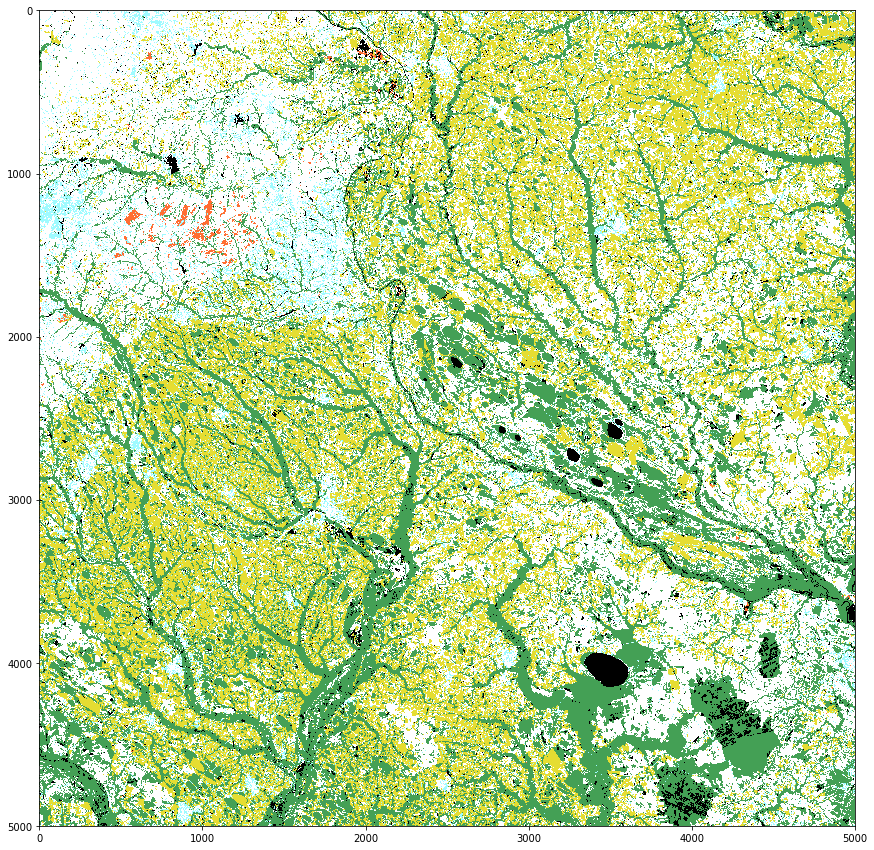

In [128]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)),  # Unclassified (Cloud, Shadow, etc)
(11, (51, 85, 189)), # Water
(12, (159, 251, 255)), # Snow/Ice
(21, (255, 162, 51)), # Open Space Developed
(22, (255, 162, 51)), # Low Intensity Developed
(23, (255, 110, 51)), # Medium Intensity Developed
(24, (255,0,0)), # High Intensity Developed
(31, (172, 177, 68)), # Bare Land
(41, (83, 144, 0)), # Deciduous Forest
(42, (13, 118, 0)), # Evergreen Forest
(43, (62, 178, 49)), # Mixed Forest
#(51, (100, 241, 125)), # Dwarf Scrub/Shrub - ALASKA
(52, (100, 241, 125)), # Scrub/Shrub
(71, (185, 251, 96)), # Grassland / Herbaceous
#(72, (185, 251, 96)), # Sedge / Herbaceous - ALASKA
#(73, (185, 251, 96)), # Lichen / Herbaceous - ALASKA
#(74, (185, 251, 96)), # Moss - ALASKA
(81, (229, 221, 50)), # Pasture/Hay
(82, (162, 89, 0)), # Cultivated Land
(90, (68, 160, 85)), # Woody Wetland
(95, (172, 0, 191)), # Emergent Herbaceous Wetlands
))

n = int(np.max(label_image))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (0, 0, 0, 0) for key in range(1, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, axs = plt.subplots(figsize=(15,15))

axs.imshow(label_image[0,:, :], cmap=cmap, interpolation='none')

plt.show()

Since that isn't very informative let's add a colormap and visualize what's really there

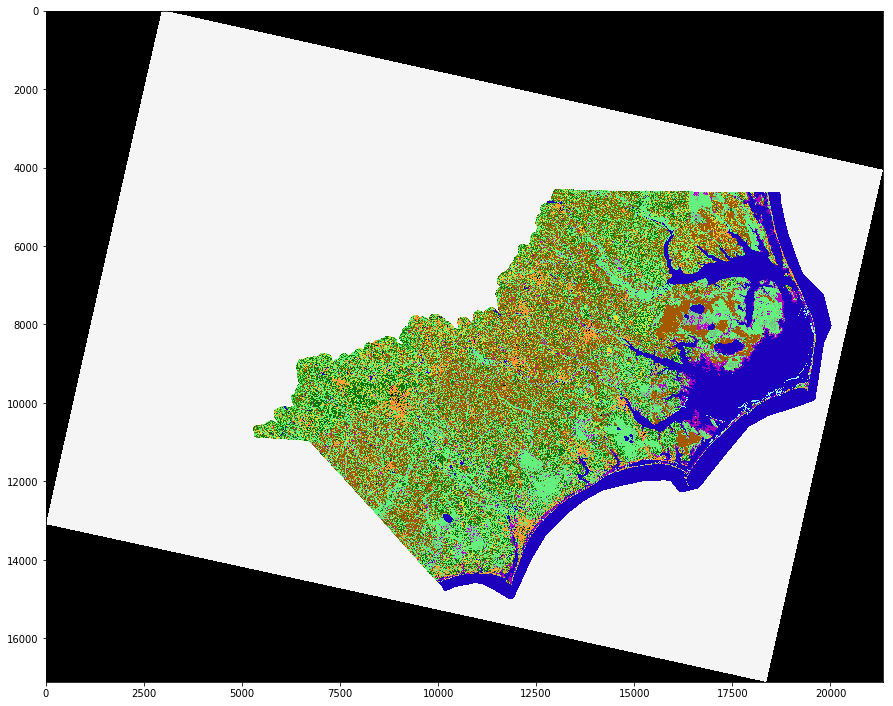

In [147]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (29, 0, 189)), # Palustrine Aquatic Bed
(23, (91, 199, 169)), # Estuarine Aquatic Bed
(24, (159, 251, 255)), # Tundra
(25, (159, 251, 255)), # Snow/Ice
))

n = int(np.max(label_image))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, axs = plt.subplots(figsize=(15,15))

axs.imshow(label_image[0,:, :], cmap=cmap, interpolation='none')
#axs.imshow(image[0,:, :], cmap=cmap, interpolation='none')

plt.show()

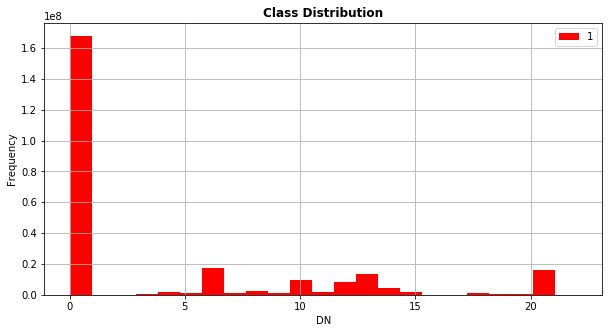

In [148]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(label_dataset, ax=ax, bins=len(np.unique(label_image)), lw=0.0, stacked=False, 
               histtype='stepfilled', title="Class Distribution")

In [3]:
label_dataset.close()

## Moving to Landsat Inspection

In [3]:
image_index = 0

In [4]:
l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif',
]
l8_filename = l8_image_paths[image_index]

In [5]:
#l8_filename = '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif'

image_dataset = rasterio.open(l8_filename)

# How many bands does this image have?
num_bands = image_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = image_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = image_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = image_dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 8

Image size is: 5000 rows x 5000 columns

Raster driver: GTiff

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]



#### Let's just visualize it to see what's going on

(3, 5000, 5000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


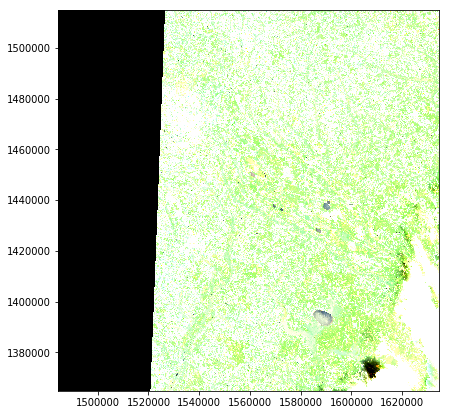

In [6]:
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

full_img = image_dataset.read()
clipped_img = full_img[[3, 2, 1], :, :]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=image_dataset.transform) # add the transform arg to get it in lat long coords

#### Not very informative...

Let's try to normalize it with the built in rasterio adjust_band function

Text(0.5, 1.0, 'RGB in matplotlib imshow')

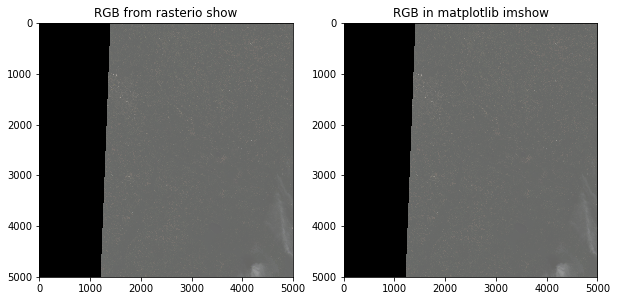

In [7]:
from rasterio.plot import adjust_band, show_hist

img_norm = adjust_band(clipped_img) # normalize bands to range between 1.0 to 0.0
img_reshaped = reshape_as_image(img_norm) # reshape to [rows, cols, bands]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# the rasterio show function takes in [bands, rows, cols] so we don't need to reshape
show(img_norm, ax=axs[0])
axs[0].set_title("RGB from rasterio show")

# plot with normal matplotlib functions
axs[1].imshow(img_reshaped)
axs[1].set_title("RGB in matplotlib imshow")

Still not very useful, let's check out the historgram and normalize it ourselves

In [8]:
print(np.amax(full_img))
print(np.amin(full_img))

15917
-9999


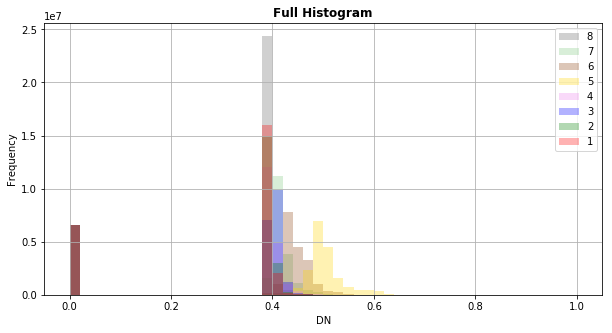

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(image_dataset, ax=ax, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="Full Histogram")

In [9]:
from rasterio.plot import reshape_as_raster, reshape_as_image

# Extract reference to SWIR1, NIR, and Red bands
index = np.array([3, 2, 1])
colors = full_img[index, :, :].astype(np.float64)

max_val = 4000
min_val = 0

# Enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)

(3, 5000, 5000)
(5000, 5000, 3)


Text(0.5, 1.0, 'RGB in matplotlib imshow')

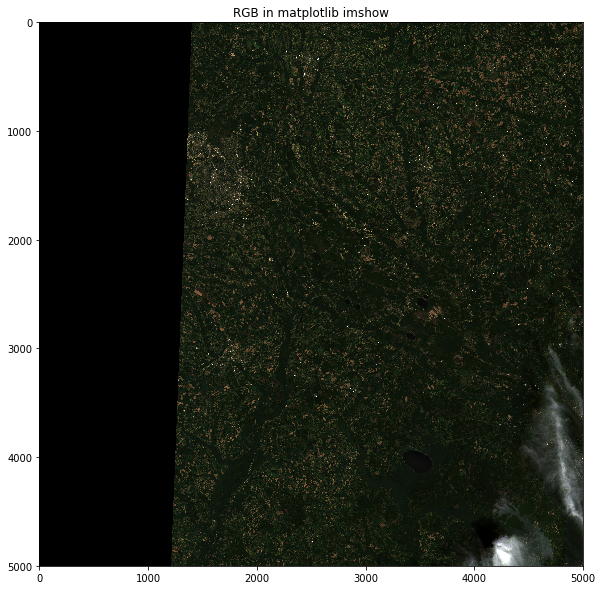

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

# plot with normal matplotlib functions
ax.imshow(colors_reshaped)
ax.set_title("RGB in matplotlib imshow")

### okay that's what it should really look like!

(1, 5000, 5000)


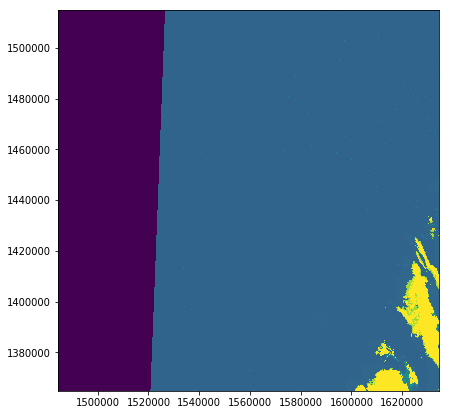

In [11]:
#### now let's check out the quality band
clipped_img = full_img[[7], :, :]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=image_dataset.transform)
# show(clipped_img[:, :, :], ax=ax, transform=image_dataset.transform) # add the transform arg to get it in lat long coords

Looks good too!

### Now let's inspect where it is on the map

In [12]:
from pyproj import transform
# this will get our four corner points
raster_utm_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(image_dataset.crs) # our current crs
p2 = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ") # the crs we want our raster to be in

# use the pyproj.transform function to convert the positions to longs, lats
lats, longs = transform(p1, p2, np.array(raster_utm_points)[:,0],np.array(raster_utm_points)[:,1])

raster_gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

print('raster bounds in UTM 18N:\n', raster_utm_points, '\n')
print('raster bounds in lat, lon:\n', raster_gps_points)

raster bounds in UTM 18N:
 ((1484415.0, 1514805.0), (1634415.0, 1514805.0), (1634415.0, 1364805.0), (1484415.0, 1364805.0)) 

raster bounds in lat, lon:
 [(-79.40507192506966, 35.51886361214416), (-77.7671965255445, 35.27465758044477), (-78.07896077506945, 33.957621537811946), (-79.69000760805608, 34.198029812561515)]


In [13]:
import folium # let's make an interactive map using leaflet

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
raster_gps_reversed = list(zip(np.array(raster_gps_points)[:,1], np.array(raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=11) # set the map centered around the first point

# this actually adds the polygon to the map
folium.Polygon(raster_gps_reversed, 
               popup='Landsat 8 Image Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc'
              ).add_to(m)

m

In [38]:
image_dataset.close()

### Sentinel SAR Data

In [18]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [40]:

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]
sent1_fn = s1_image_paths[image_index]

In [41]:
image_dataset = rasterio.open(sent1_fn)
# How many bands does this image have?
num_bands = image_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = image_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = image_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = image_dataset.crs
print('Image projection:')
print(proj)

pixelSizeX, pixelSizeY  = image_dataset.res
print(pixelSizeX)
print(pixelSizeY)

Number of bands in image: 2

Image size is: 5000 rows x 5000 columns

Raster driver: GTiff

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
30.0
30.0


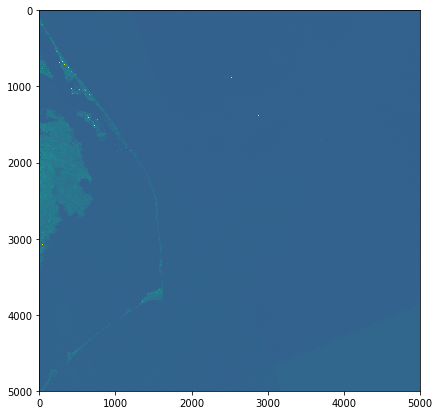

In [42]:
plot_image(image_dataset.read()[0,:,:])

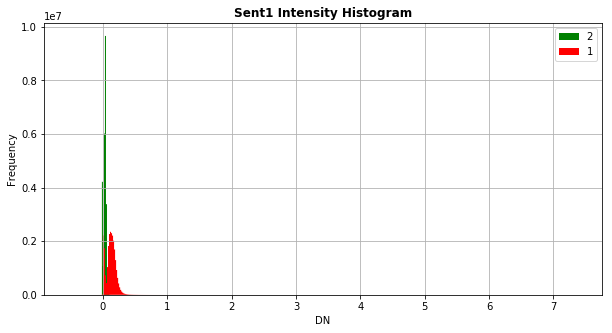

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(image_dataset, ax=ax, bins=500, lw=0.0, stacked=False, histtype='stepfilled', title="Sent1 Intensity Histogram")

In [43]:
s1_raster_utm_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(image_dataset.crs) # our current crs
p2 = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ") # the crs we want our raster to be in

# use the pyproj.transform function to convert the positions to longs, lats
lats, longs = transform(p1, p2, np.array(s1_raster_utm_points)[:,0],np.array(s1_raster_utm_points)[:,1])

s1_raster_gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
s1_raster_gps_reversed = list(zip(np.array(s1_raster_gps_points)[:,1], np.array(s1_raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=8) # set the map centered around the first point

# this actually adds the polygon to the map
folium.Polygon(raster_gps_reversed, 
               popup='Landsat 8 Image Bounds',
               color='#800080',
               fill=True,
               fill_color='#800080'
              ).add_to(m)

folium.Polygon(s1_raster_gps_reversed, 
               popup='Sentinel-1 Image Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc'
              ).add_to(m)

m

In [44]:
image_dataset.close()

In [45]:
dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',

]
dem_fn = dem_image_paths[image_index]

In [46]:
image_dataset = rasterio.open(dem_fn)
# How many bands does this image have?
num_bands = image_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = image_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = image_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = image_dataset.crs
print('Image projection:')
print(proj)

pixelSizeX, pixelSizeY  = image_dataset.res
print(pixelSizeX)
print(pixelSizeY)

Number of bands in image: 1

Image size is: 5000 rows x 5000 columns

Raster driver: GTiff

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
30.0
30.0


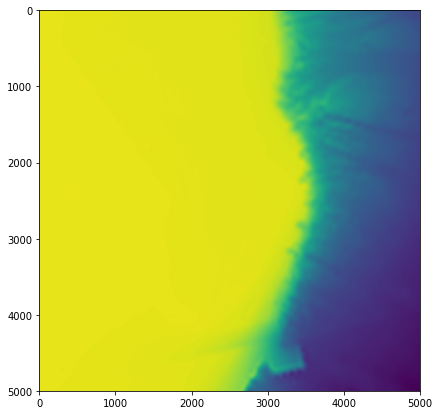

In [47]:
dem_image = image_dataset.read()[0,:,:]
plot_image(dem_image, 1 / np.amax(dem_image))

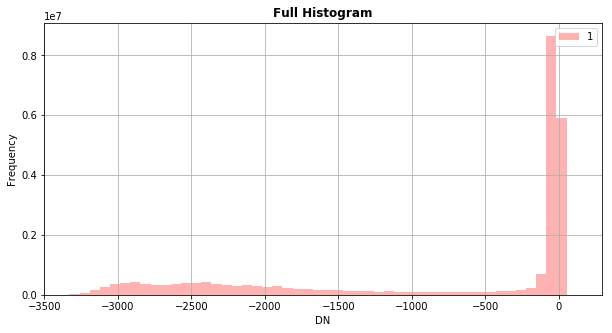

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(image_dataset, ax=ax, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="Full Histogram")

In [49]:
np.median(image_dataset.read())

-39.0

In [50]:
dem_raster_utm_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(image_dataset.crs) # our current crs
p2 = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ") # the crs we want our raster to be in

# use the pyproj.transform function to convert the positions to longs, lats
lats, longs = transform(p1, p2, np.array(dem_raster_utm_points)[:,0],np.array(dem_raster_utm_points)[:,1])

dem_raster_gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
dem_raster_gps_reversed = list(zip(np.array(dem_raster_gps_points)[:,1], np.array(dem_raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=8) # set the map centered around the first point

# this actually adds the polygon to the map
folium.Polygon(raster_gps_reversed, 
               popup='Landsat 8 Image Bounds',
               color='#800080',
               fill=True,
               fill_color='#800080'
              ).add_to(m)

folium.Polygon(s1_raster_gps_reversed, 
               popup='Sentinel-1 Image Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc'
              ).add_to(m)

folium.Polygon(dem_raster_gps_reversed, 
               popup='DEM Image Bounds',
               color='#ffdab9',
               fill=True,
               fill_color='#ffdab9'
              ).add_to(m)

m

In [51]:
image_dataset.close()

In [22]:
ndvi_yearly_paths = ['/deep_data/ndvi_yearly/aligned-stackedImage_027012_20170907.tif']
ndvi_dataset = rasterio.open(ndvi_yearly_paths[0])
# How many bands does this image have?
num_bands = ndvi_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = ndvi_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = ndvi_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = ndvi_dataset.crs
print('Image projection:')
print(proj)

pixelSizeX, pixelSizeY  = ndvi_dataset.res
print(pixelSizeX)
print(pixelSizeY)

Number of bands in image: 12

Image size is: 5000 rows x 5000 columns

Raster driver: GTiff

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
30.0
30.0


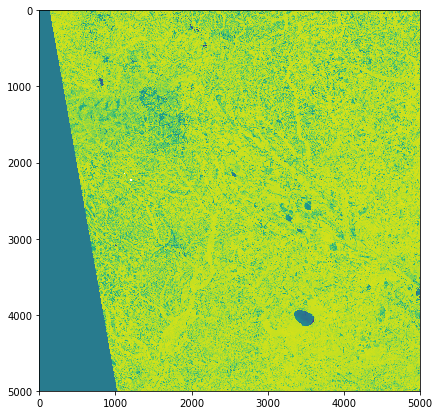

In [37]:
ndvi_image = ndvi_dataset.read()
plot_image(ndvi_image[7,:,:])

In [41]:
np.count_nonzero(ndvi_image[:, 0, 0])

0

In [28]:
np.unique(np.isnan(ndvi_image) , return_counts=True)

(array([False,  True]), array([24999380,      620]))

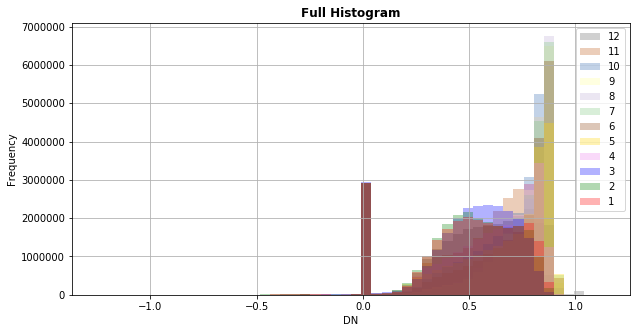

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(ndvi_dataset, ax=ax, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="Full Histogram")

In [29]:
ndvi_raster_utm_points = ndvi_dataset.transform * (0, 0), ndvi_dataset.transform * (ndvi_dataset.width, 0), ndvi_dataset.transform * (ndvi_dataset.width, ndvi_dataset.height), ndvi_dataset.transform * (0, ndvi_dataset.height)

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(ndvi_dataset.crs) # our current crs
p2 = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ") # the crs we want our raster to be in

# use the pyproj.transform function to convert the positions to longs, lats
lats, longs = transform(p1, p2, np.array(ndvi_raster_utm_points)[:,0],np.array(ndvi_raster_utm_points)[:,1])

ndvi_raster_gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
ndvi_raster_gps_reversed = list(zip(np.array(ndvi_raster_gps_points)[:,1], np.array(ndvi_raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = ndvi_raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=8) # set the map centered around the first point

# this actually adds the polygon to the map
# folium.Polygon(raster_gps_reversed, 
#                popup='Landsat 8 Image Bounds',
#                color='#800080',
#                fill=True,
#                fill_color='#800080'
#               ).add_to(m)

# folium.Polygon(s1_raster_gps_reversed, 
#                popup='Sentinel-1 Image Bounds',
#                color='#3186cc',
#                fill=True,
#                fill_color='#3186cc'
#               ).add_to(m)

# folium.Polygon(dem_raster_gps_reversed, 
#                popup='DEM Image Bounds',
#                color='#ffdab9',
#                fill=True,
#                fill_color='#ffdab9'
#               ).add_to(m)

folium.Polygon(ndvi_raster_gps_reversed, 
               popup='NDVI Image Bounds',
               color='#ffdab9',
               fill=True,
               fill_color='#ffdab9'
              ).add_to(m)

m